# Thunderstruck
## Figure 4. Vertical profiles.

In [1]:
from dataclasses import dataclass, field
from functools import partial

import iris
import matplotlib.colors as mcol
import matplotlib.pyplot as plt
import numpy as np
import paths
from aeolus.calc import precip_sum, spatial_mean
from aeolus.const import init_const
from aeolus.core import AtmoSim
from aeolus.model import um
from aeolus.plot import (
    add_custom_legend,
    figsave,
    subplot_label_generator,
    tex2cf_units,
    unit_format,
)
from aeolus.region import Region
from matplotlib.offsetbox import AnchoredText

In [2]:
from common import (
    ACCUM_PERIOD,
    DAYSIDE,
    GROUPS,
    KW_DELIM_LINE,
    KW_TEXT,
    LPC,
    M09,
    PR92,
    PROJECT,
    SIMULATIONS,
    calc_cloud_depth,
    calc_flash_rate,
    calc_total_flash_rate,
    callback_coord_system,
    extract_lfr_ratio,
)

In [3]:
SIM_GROUP = "pres"
show_groups = [SIM_GROUP]  # "comp", "surf"
show_sim = [
    sim
    for sim in SIMULATIONS.keys()
    if sim in sum([GROUPS[SIM_GROUP].simulations for SIM_GROUP in show_groups], ())
]
n_sim = len(show_sim)

In [4]:
dset = {}
for sim in show_sim:
    dset[sim] = {}
    const = init_const("trap1e")  # TODO
    for scheme in LPC:
        dset[sim][scheme] = AtmoSim(
            iris.load(
                paths.data
                / "raw"
                / "steady"
                / SIMULATIONS[sim].diag_suites[LPC[scheme].suites]
                / "base"
                / LPC[scheme].model_res.lower()
                / LPC[scheme].file_mask,
                callback=partial(callback_coord_system, const=const),
            ),
            planet="trap1e",  # TODO
            model=um,
        )

In [5]:
for scheme in LPC:
    for i, cube in enumerate(dset[sim][scheme]._cubes):
        print(f"--|-|-{'-'*20}-|-{'-'*10}-|-{'-'*65}-|-{'-'*10}")
        print(
            f"{i:<2d}|{cube.ndim}| {str(cube.shape):>20}"
            f" | {str(cube.attributes['STASH']):>10}"
            f" | {cube.name():>65} | {str(cube.units):>10}"
        )
    print("-" * 120)

--|-|----------------------|------------|-------------------------------------------------------------------|-----------
0 |3|     (10, 1920, 2560) | m01s09i217 |               cloud_area_fraction_assuming_maximum_random_overlap |          1
--|-|----------------------|------------|-------------------------------------------------------------------|-----------
1 |3|     (10, 1920, 2560) | m01s21i102 |                                                graupel_water_path |     kg m-2
--|-|----------------------|------------|-------------------------------------------------------------------|-----------
2 |3|     (10, 1920, 2560) | m01s21i103 |                                              total_ice_water_path |     kg m-2
--|-|----------------------|------------|-------------------------------------------------------------------|-----------
3 |3|     (10, 1920, 2560) | m01s21i104 |                                       Number_of_lightning_flashes |          1
--|-|----------------------|----

In [6]:
@dataclass
class Diag:
    recipe: callable
    title: str
    units: str
    short_label: str = ""
    lim: tuple = ()
    scale: str = "linear"
    unit_format_kwargs: dict = field(default_factory=lambda: {})
    scheme: str = "m09"
    kw_plt: dict = field(default_factory=lambda: {})

In [7]:
DIAGS = {
    "temp": Diag(
        recipe=lambda cl: cl.extract_cube(um.temp),
        title="Air Temperature",
        units="$K$",
    ),
    "m_ci": Diag(
        recipe=lambda cl: cl.extract_cube("cloud_ice_mixing_ratio"),
        title="Cloud Ice",
        short_label="Mixing Ratio",
        units="$kg$ $kg^{-1}$",
        scale="log",
        lim=[1e-9, 1e-4],
    ),
    "m_cl": Diag(
        recipe=lambda cl: cl.extract_cube("cloud_liquid_water_mixing_ratio"),
        title="Cloud Liquid Water",
        short_label="Mixing Ratio",
        units="$kg$ $kg^{-1}$",
        scale="log",
        lim=[1e-9, 1e-4],
    ),
    "m_g": Diag(
        recipe=lambda cl: cl.extract_cube("graupel_mixing_ratio"),
        title="Graupel",
        short_label="Mixing Ratio",
        units="$kg$ $kg^{-1}$",
        scale="log",
        lim=[1e-13, 1e-8],
    ),
    "cld_v": Diag(
        recipe=lambda cl: cl.extract_cube("cloud_volume_fraction_in_atmosphere_layer"),
        title="Cloud Volume Fraction",
        units="%",
        lim=[0, 100],
    ),
}

Saved to ../figures/thunderstruck__pres__temp_m_ci_m_cl_m_g__vert_prof.pdf
Size: 37.7 KB


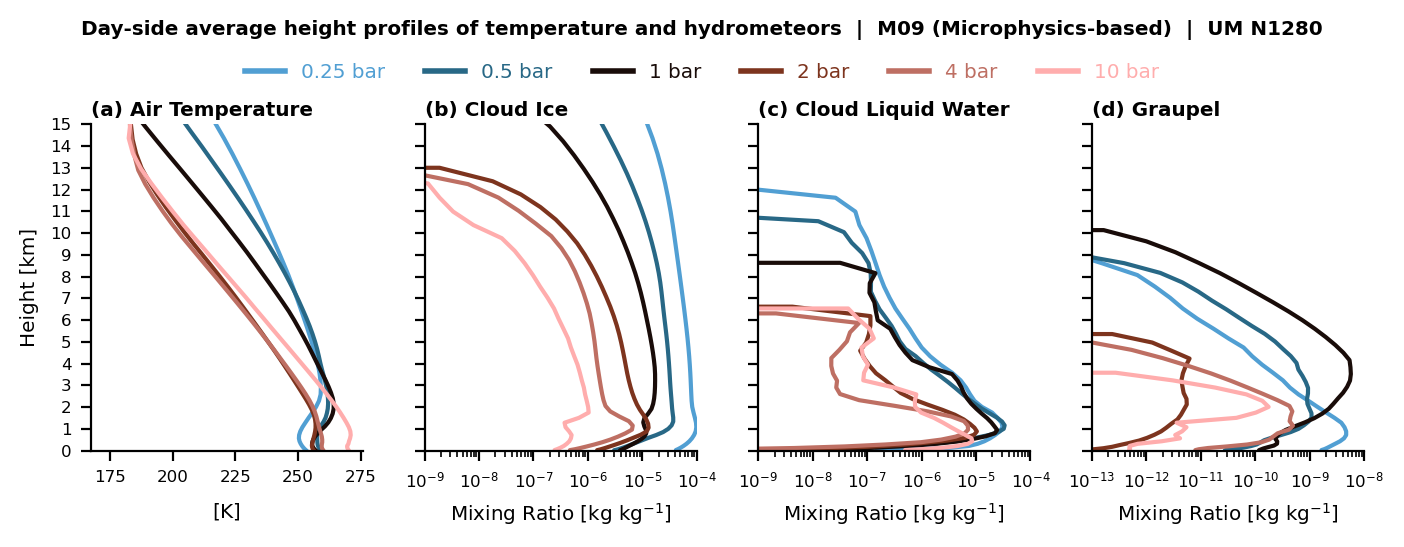

In [8]:
area_mean = lambda cube: spatial_mean(cube.extract(DAYSIDE.constraint))
scheme = "m09"
diag_keys = ["temp", "m_ci", "m_cl", "m_g"]
sep = "  |  "
savefig = True

ttl = sep.join(
    [
        "Day-side average height profiles of temperature and hydrometeors",
        LPC[scheme].title,
        f"UM {LPC[scheme].model_res}",
    ]
)

fig = plt.figure(figsize=(7, 2.5), layout="tight")
fig.suptitle(ttl, y=1.05)
add_custom_legend(
    fig,
    {
        SIMULATIONS[sim].title: {
            "color": SIMULATIONS[sim].kw_plt["color"],
            "lw": 2,
        }
        for sim in GROUPS[SIM_GROUP].simulations
    },
    ncol=len(GROUPS[SIM_GROUP].simulations),
    loc="upper center",
    frameon=False,
    fontsize="large",
    bbox_to_anchor=(0.5, 1),
)

axd = fig.subplot_mosaic([diag_keys], sharey=True)

iletters = subplot_label_generator()

for diag_key in diag_keys:
    ax = axd[diag_key]
    ax.set_title(f"({next(iletters)}) {DIAGS[diag_key].title}", loc="left")

    for isim, sim in enumerate(GROUPS[SIM_GROUP].simulations):
        cube = DIAGS[diag_key].recipe(dset[sim][DIAGS[diag_key].scheme]._cubes)
        cube.convert_units(tex2cf_units(DIAGS[diag_key].units))
        cube1d = area_mean(LPC[scheme].time_ave_func(cube))
        ax.plot(
            cube1d.data,
            cube1d.coord(um.z).points / 1e3,  # km
            # marker=SIMULATIONS[sim].kw_plt["marker"],
            # markersize=4,
            # markeredgecolor="w",
            color=SIMULATIONS[sim].kw_plt["color"],
        )
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Height [km]", size="large")
    ax.set_ylim(0, 15)
    ax.set_xlabel(
        f"{DIAGS[diag_key].short_label} [{DIAGS[diag_key].units}]".removeprefix(" "),
        size="large",
    )
    ax.set_xscale(DIAGS[diag_key].scale)
    if DIAGS[diag_key].lim:
        ax.set_xlim(DIAGS[diag_key].lim)
        ax.spines.bottom.set_bounds(DIAGS[diag_key].lim)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    # ax.spines.left.set_visible(False)
    ax.spines.left.set_bounds(0, 15)
    ax.set_yticks(range(16))

fig.align_labels()

if savefig:
    figsave(
        fig,
        paths.figures / f"{PROJECT}__{SIM_GROUP}__{'_'.join(diag_keys)}__vert_prof",
    )